# Sentiment Analysis of Edgar Company Filings

- Cohen, Malloy and Nguyen (2020), Loughran and McDonald (2011), and others
- sklearn, nltk, SEC Edgar, Wharton Research Data Services

Terence Lim

In [1]:
import re
import os
import requests
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sklearn.feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
from finds.database import SQL, MongoDB, Redis
from finds.structured import CRSP, Signals
from finds.busday import BusDay
from finds.unstructured import Unstructured
from finds.readers import fetch_lm
from finds.solve import weighted_average, fractiles
from finds.edgar import Edgar
from settings import settings

ECHO = False
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bd = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bd, rdb)
ed = Edgar(settings['10X'], echo=ECHO)    
signals = Signals(user)
mongodb = MongoDB(**settings['mongodb'])
wordlists = Unstructured(mongodb, 'WordLists')
imgdir = os.path.join(settings['images'], 'edgar')

## Retrieve Loughran McDonald stopword and sentiment word files

In [2]:
# scrape LM's web page for all google drive filenames
url = 'https://sraf.nd.edu/textual-analysis/resources/'
r = requests.get(url).text  
files = {re.search('>(.*)?</a>', h).group(1):
         re.search('/file/d/(.*)?/view', h).group(1) for h in
         re.findall('<a\s+?href.*?https://drive.google.com/file.*?</a>', r)}

# construct links to download master and all StopWords_* files
source = "https://drive.google.com/uc?export=download&id="
master = files['csv format']  # master file is csv format
stopfiles = {re.search('StopWords_(.*)\.txt', k, re.I).group(1).lower(): 
             v for k,v in files.items() if 'stopwords_' in k.lower()}
Series({'Master': master}).append(Series(stopfiles)).rename('file_id')

# retrieve word dictionaries
words = fetch_lm(source + master)
for stopword, file_id in stopfiles.items():
    words.update(fetch_lm(source + file_id, stopword))
Series({k: len(v) for k,v in words.items()}, name='count').to_frame().T

,negative,positive,uncertainty,litigious,constraining,superfluous,interesting,irr_verb,strong,moderate,weak,generic,auditor,currencies,datesandtime,genericlong,geographic,names
count,2355,354,297,904,184,56,68,158,19,14,27,120,7,84,108,570,198,13013


## Retrieve Item 1 Business Description for 'AAPL' from 10K filing in edgar
- compare years 2003 and 2020


In [3]:
ticker = 'AAPL'
cik = ed.fetch_tickers()[ticker.lower()]              # lookup aapl's cik
stop_words = [w for c in ['genericlong', 'DatesandNumbers']
              for w in wordlists['lm', c.lower()]] # if "'" not in w]
top_words = {}
for year in [2003, 2020]:
    files = ed.fetch_index(year=year, quarter=4)  # 
    r = files[files['cik'].eq(cik) & files['form'].isin(ed.forms_['10-K'])]
    htmls = ed.extract_filename(ed.fetch_detail(r.iloc[0]['pathname']))
    filing = ed.fetch_filing(ed.from_pathname(r.iloc[0]['pathname'],htmls[0]))
    text = ed.extract_item(filing, 'bus10K')
    print('***', ticker, year, 'business description:')
    print(text[:500])
    print()
    words = text.lower()
    tokenizer = RegexpTokenizer(r"\b[^\d\W][^\d\W][^\d\W]+\b")
    unigrams = [t for t in tokenizer.tokenize(words) if t not in stop_words]
    counts = Series(unigrams).value_counts()
    unigrams = [t for t in unigrams if t not in counts[counts > 40].index]
    unigram_counts = Series(unigrams).value_counts()
    bigrams = [a + '_' + b for a,b in zip(unigrams[:-1], unigrams[1:])]
    bigram_counts = Series(bigrams).value_counts()
    top_n = 20
    top_words[year] = bigram_counts.iloc[:top_n].to_dict()
DataFrame(top_words).fillna(0).astype(int)

*** AAPL 2003 business description:
ITEM 1. BUSINESS

COMPANY BACKGROUND

APPLE COMPUTER, INC. ("APPLE" OR THE "COMPANY") WAS INCORPORATED UNDER THE LAWS OF THE STATE OF CALIFORNIA ON JANUARY 3, 1977. THE COMPANY DESIGNS, MANUFACTURES

AND MARKETS PERSONAL COMPUTERS AND RELATED SOFTWARE, PERIPHERALS AND PERSONAL COMPUTING AND COMMUNICATING SOLUTIONS. THE COMPANY'S PRODUCTS INCLUDE THE MACINTOSH® LINE OF DESKTOP AND

NOTEBOOK COMPUTERS, THE MAC OS® X OPERATING SYSTEM, THE IPOD DIGITAL MUSIC PLAYER, AND A PORTFOLIO OF SOFTWARE AND 

*** AAPL 2020 business description:
ITEM 1.    BUSINESS

COMPANY BACKGROUND

THE COMPANY DESIGNS, MANUFACTURES AND MARKETS SMARTPHONES, PERSONAL COMPUTERS, TABLETS, WEARABLES AND ACCESSORIES, AND SELLS A VARIETY OF RELATED SERVICES. THE COMPANY’S FISCAL YEAR IS THE 52- OR 53-WEEK PERIOD THAT ENDS ON THE LAST SATURDAY OF SEPTEMBER. THE COMPANY IS A CALIFORNIA CORPORATION ESTABLISHED IN 1977.

PRODUCTS

IPHONE

IPHONE

®

IS THE COMPANY’S LINE OF SMARTPHONES B

,2003,2020
itunes_store,16,0
final_cut,11,0
macintosh_systems,10,0
personal_computers,10,5
personal_computer,9,0
operating_system,9,5
high_quality,9,0
education_customers,8,0
united_states,8,0
cut_pro,8,0


## Display as wordcloud

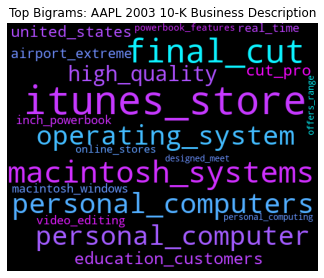

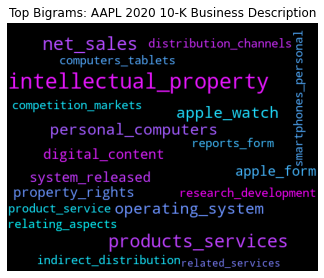

In [4]:
for num, (year, words) in enumerate(top_words.items()):
    wc = WordCloud(height=400, width=500,  colormap='cool')
    fig, ax = plt.subplots(1, 1, num=num+1, clear=True, figsize=(5,4))
    ax.imshow(wc.generate_from_frequencies(words))
    ax.axis("off")
    plt.tight_layout(pad=2)
    ax.set_title(f"Top Bigrams: {ticker} {year} 10-K Business Description")
    plt.savefig(os.path.join(imgdir, f"{ticker}{year}.jpg"))
plt.show()

## Retrieve sentiment words and stopwords from database

In [5]:
mongodb = MongoDB()
wordlists = Unstructured(mongodb, 'WordLists')
sentiments = {k : wordlists['lm', k] for k in ['positive', 'negative']}

## use sklearn text pre-processing tools

In [6]:
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    # tokenizer=CustomTokenizer(),
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")
tokenize = tf_vectorizer.build_tokenizer()
analyze = tf_vectorizer.build_analyzer()

## Construct sentiment feature all years for usual universe


In [8]:
univs = {yr+1: crsp.get_universe(bd.endmo(yr*10000 + 1231)).assign(year=yr+1)
         for yr in range(1992, 2021)}
results = []
item, forms = 'mda10K', ['10-K']
folders, root = ed.archive_index(item=item, zip=False)
tic = time.time()
permnos = folders['permno'].unique().astype(int)
for i, permno in enumerate(permnos):  # Loop over all permnos
    # retrieve all valid mda's for this permno by year
    mdas = {}
    dates = {}
    files, root = ed.archive_index(item=item, permno=permno, zip=False)
    for _, f in files.iterrows():
        year = int(f['date'])//10000 - (((f['date']//100)%100)<=3) # Mar yearend
        if f['form'] in forms and year in univs:
            tokens = Series(analyze(ed.archive_filing(f['pathname'], root)))
            if len(tokens):
                mdas[year] = tokens
                dates[year] = f['date']
    # compute sentiment scores for this permno by year
    sentiment = {year: (mda.isin(sentiments['positive']).sum() -
                        mda.isin(sentiments['negative']).sum()) / len(mda)
                 for year, mda in mdas.items()}  # compute sentiment by year

    # derive sentiment change and similarity scores by year
    for year in sorted(mdas.keys()):
        result = {'year': year, 'permno': permno, 'date': dates[year]}
        result['mdasent'] = sentiment[year]
        result['currlen'] = len(mdas[year])
        if year-1 in mdas:
            result['prevlen'] = len(mdas[year-1])
            result['mdachg'] = sentiment[year] - sentiment[year-1]
            
            corpus = [" ".join(mdas[year]), " ".join(mdas[year-1])]
            cos = cosine_similarity(tf_vectorizer.fit_transform(corpus))
            result['mdacos'] = cos[0, 1]
        if ECHO: print(i, int(time.time()-tic), result)
        results.append(result)

r = results.copy()
results = DataFrame.from_records(results)
results['rebaldate'] = bd.offset(results['date'])
print(signals.write(results, 'mdasent', overwrite=True),
      signals.write(results, 'mdachg', overwrite=True),
      signals.write(results, 'mdacos', overwrite=True))

# right merge data with univ -- with univ.year for missing mda
data = pd.concat([results[results['year']==year]\
                  .drop(columns=['year'])\
                  .set_index('permno')\
                  .join(univ[['year']], how='right')\
                  .reset_index()
                  for year, univ in univs.items() if year <= 2020],
                 ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


103739 85132 85132


In [9]:
#from settings import pickle_load, pickle_dump
#pickle_dump(data, 'data.sentiment.2')  # save in scratch folder
#data = pickle_load('data.sentiment')

## display sentiment of extreme documents

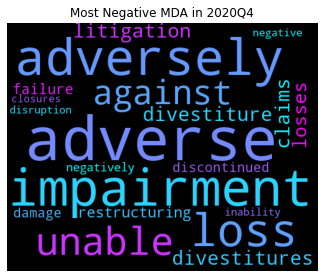

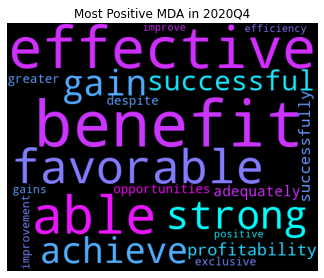

In [10]:
docs = data[data['date'] >= 20201001].sort_values('mdasent')
for ifig, (iloc, sense) in enumerate({0: 'negative', -1:'positive'}.items()):
    files, root = ed.archive_index(permno=int(docs.iloc[0]['permno']),
                                   item='mda10K', zip=False)
    tokens = analyze(ed.archive_filing(max(files['pathname']), root))
    words = Series([t for t in tokens if t in sentiments[sense]]).value_counts()
    wc = WordCloud(width=500, height=400, colormap='cool') 
    top_n = 20
    fig, ax = plt.subplots(num=1+ifig, clear=True, figsize=(5, 4))
    ax.imshow(wc.generate_from_frequencies(words.iloc[:top_n].to_dict()))
    ax.axis("off")
    plt.tight_layout(pad=2)
    ax.set_title(f"Most {sense.capitalize()} MDA in 2020Q4")
    plt.savefig(os.path.join(imgdir, f"{sense}.jpg"))
plt.show()
    

## Stacked Bar Plot of universe coverage by year


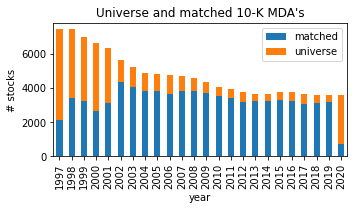

In [11]:
y1 = data[data['mdasent'].notna()].groupby('year')['permno'].count()
y0 = data[data['mdasent'].isna()].groupby('year')['permno'].count()\
                                                           .reindex(y1.index)
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(5,3))
y1.plot(kind='bar', label='matched', color='C0', ax=ax, rot=90)
y0.plot(kind='bar', label='universe', color='C1', ax=ax, rot=90, bottom=y1)
ax.set_ylabel('# stocks')
ax.set_title("Universe and matched 10-K MDA's")
ax.legend()
plt.tight_layout(pad=1)
plt.savefig(os.path.join(imgdir, 'coverage.jpg'))
plt.show()

## Stacked Bar Plot of filings by month, by day-of-week

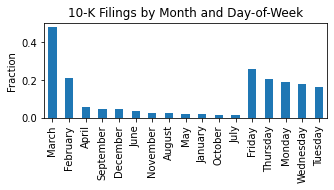

In [12]:
y = DataFrame.from_records([{'date': d, 'day': bd(d).strftime('%A'),
                             'month': bd(d).strftime('%B')}
                            for d in data.loc[data['mdasent'].notna(), 'date']])
z = (y['month'].value_counts()/len(y)).append(y['day'].value_counts()/len(y))
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(5,3))
z.plot(kind='bar', color='C0', ax=ax, rot=90)
ax.set_ylabel('Fraction')
ax.set_title("10-K Filings by Month and Day-of-Week")
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'calendar.jpg'))
plt.show()

## Plot of average sentiment, change, cosine similarity by year
- visualize with economy-wide profitabality (CP Corporate Profits from FRED)

### Align year as caldate, e.g. for caldate year 2020:
-   filings from April 2020 to Mar 2021 (i.e. year = filing year-1 if month<=3)
-   universe is as of year end prior to filing date
-   economic time series is average annual value ending Dec 2020
-   concurrent return year is Jan 2020 to Dec 2020
-   next return year (i.e. lagged filings) is April 2021-Mar 2022 (if available)


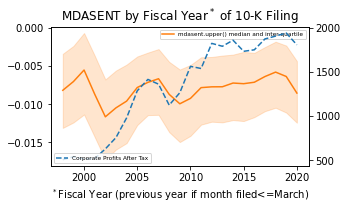

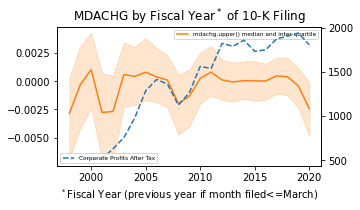

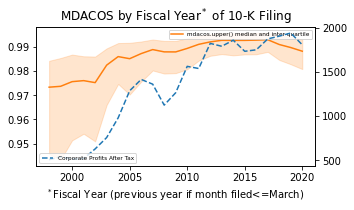

In [21]:
data = data.dropna(subset=['date'])

from finds.alfred import Alfred
al = Alfred(api_key=settings['fred']['api_key'])
series_id = 'CP'  # Corporate Profits
#series_id = 'UNRATE'
#series_id = 'WILL5000IND'
econ = al(series_id)
econ = econ.to_frame().assign(year=econ.index//10000).groupby('year').mean()

for i, c in enumerate(['mdasent', 'mdachg', 'mdacos']):
    g = data[data['currlen'].gt(500)].dropna().groupby('year')
    iq1, iq2, iq3 = [g[c].quantile(p) for p in [.25, .5, .75]]
    y = iq2.index.astype(int)
    fig, ax = plt.subplots(1, 1, clear=True, num=1+i, figsize=(5,3))
    ax.plot(y, iq2, ls='-', c='C1')
    ax.fill_between(y, iq1, iq3, alpha=0.2, color='C1')
    ax.set_title(f"{c.upper()} by Fiscal Year$^*$ of 10-K Filing")
    ax.set_xlabel("$^*$Fiscal Year (previous year if month filed<=March)")
    ax.legend([f"{c}.upper() median and inter-quartile"], fontsize='xx-small')
    #econ.index = ax.get_xticks()   # boxplot(by) has sequential xticks
    bx = ax.twinx()
    econ[(econ.index >= min(y)) & (econ.index<=max(y))].plot(ls='--', ax=bx)
    bx.legend([al.header(series_id)[:27]],fontsize='xx-small',loc='lower left')
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(imgdir, f'{c}.jpg'))
plt.show()

## Quintile cap-weighted spread portfolio returns

For filing date in year
- same year filings:
      stock returns are year [year]0101 to [year]1231 = bd.begyr(caldate) to caldate
- lagged filings:
      stock returns are from [year+1]0401 to [year+2]0331 = bd.begmo(caldate, 4) - bd.endmo(caldate, 15)

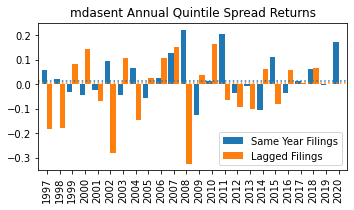

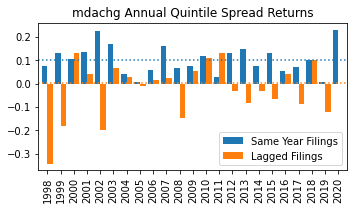

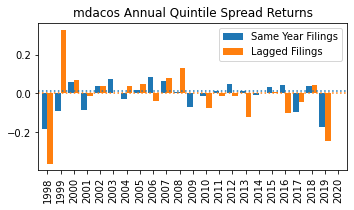

In [14]:
for ifig, key in enumerate(['mdasent', 'mdachg', 'mdacos']):
    ret1 = {}
    ret0 = {}
    for year in sorted(np.unique(data['year'])):
        # current year
        beg = bd.begyr(year)
        end = bd.endyr(year)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1,['cap','ret']],'cap')['ret']
            neg = weighted_average(univ.loc[sub==3,['cap','ret']],'cap')['ret']
            ret0[end] = {'ret':pos-neg, 'npos':sum(sub==1), 'nneg':sum(sub==3)}
            if ECHO: print(end, len(univ), pos, neg)
        # year ahead
        beg = bd.begmo(end, 4)
        end = bd.endmo(end, 15)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1,['cap','ret']],'cap')['ret']
            neg = weighted_average(univ.loc[sub==3,['cap','ret']],'cap')['ret']
            ret1[end] = {'ret':pos-neg, 'npos':sum(sub==1), 'nneg':sum(sub==3)}
            if ECHO: print(end, len(univ), pos, neg)
        
    r0 = DataFrame.from_dict(ret0, orient='index').sort_index()
    r0.index = r0.index // 10000
    r1 = DataFrame.from_dict(ret1, orient='index').sort_index()
    r1.index = (r1.index // 10000) - 2

    fig, ax = plt.subplots(1, 1, clear=True, num=1+ifig, figsize=(5,3))
    pd.concat([r0['ret'].rename('Same Year Filings').to_frame(),
               r1['ret'].rename('Lagged Filings').to_frame()],
              join='outer', axis=1).plot(kind='bar',ax=ax, width=.85)
    ax.set_title(f"{key} Annual Quintile Spread Returns")
    ax.axhline(r0['ret'].median(), linestyle=':', color='C0')
    ax.axhline(r1['ret'].median(), linestyle=':', color='C1')
    plt.tight_layout(pad=1)
    plt.savefig(os.path.join(imgdir, f'{key}RET.jpg'))
plt.show()